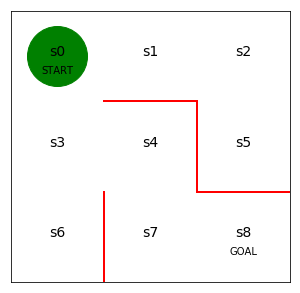

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = plt.gca()

# 붉은 벽
plt.plot([1,1], [0,1], color='red', linewidth=2)
plt.plot([1,2], [2,2], color='red', linewidth=2)
plt.plot([2,2], [2,1], color='red', linewidth=2)
plt.plot([2,3], [1,1], color='red', linewidth=2)

# 각 state 표현
plt.text(0.5, 2.5, 's0', size=14, ha ='center')
plt.text(1.5, 2.5, 's1', size=14, ha ='center')
plt.text(2.5, 2.5, 's2', size=14, ha ='center')
plt.text(0.5, 1.5, 's3', size=14, ha ='center')
plt.text(1.5, 1.5, 's4', size=14, ha ='center')
plt.text(2.5, 1.5, 's5', size=14, ha ='center')
plt.text(0.5, 0.5, 's6', size=14, ha ='center')
plt.text(1.5, 0.5, 's7', size=14, ha ='center')
plt.text(2.5, 0.5, 's8', size=14, ha ='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 그림 범위 및 눈금 제거
ax.set_xlim(0.0,3.0)
ax.set_ylim(0.0,3.0)
plt.tick_params(axis='both',which='both', bottom=False, top=False,
               labelbottom=False, right=False, left=False, labelleft=False)

# agent(원)
line, = ax.plot([0.5],[2.5], marker="o",color='g', markersize=60)

# 정책을 결정하는 파라미터의 초깃값 theta_0을 설정

# 행은 state, 열은 action 방향(상, 우, 하, 좌)
theta_0 = np.array([[np.nan, 1, 1, np.nan],
                   [np.nan, 1, np.nan, 1],
                   [np.nan, np.nan, 1, 1],
                   [1, 1, 1, np.nan],
                   [np.nan, np.nan, 1, 1],
                   [1, np.nan, np.nan, np.nan],
                   [1, np.nan, np.nan, np.nan],
                   [1, 1, np.nan, np.nan]]) #s8은 목표 지점이라 정책이 없다

In [20]:
# 행동가치 함수 Q

[a,b] = theta_0.shape
Q = np.random.rand(a,b)*theta_0
# Q에서 벽 방향으로 이동하는 행동 -> nan

In [21]:
# theta_0을 무작위 행동 정책 pi로 변환
def convert_pi_0(theta):
    [m,n] = theta.shape
    pi = np.zeros((m,n))
    for i in range(0, m):
        pi[i, :] = theta[i, :]/np.nansum(theta[i, :])
    
    pi = np.nan_to_num(pi) # nan을 0으로 변환
    return pi

pi_0 = convert_pi_0(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [22]:
#ε-greedy 함수
def get_action(s, Q, epsilon, pi_0):
    direction = ['up', 'right','down','left']
    
    # 행동을 결정
    if np.random.rand() < epsilon:
        next_direction = np.random.choice(direction, p=pi_0[s,:])
    else:
        next_direction = direction[np.nanargmax(Q[s,:])]
    
    if next_direction == 'up':
        action = 0
    if next_direction == 'right':
        action = 1
    if next_direction == 'down':
        action = 2
    if next_direction == 'left':
        action = 3
    
    return action

def get_s_next(s,a,Q,epsilon,pi_0):
    direction = ['up', 'right','down','left']
    next_direction = direction[a]
    if next_direction == 'up':
        s_next = s-3
    if next_direction == 'right':
        s_next = s+1
    if next_direction == 'down':
        s_next = s+3
    if next_direction == 'left':
        s_next = s-1
    
    return s_next
        

### sarsa 알고리즘
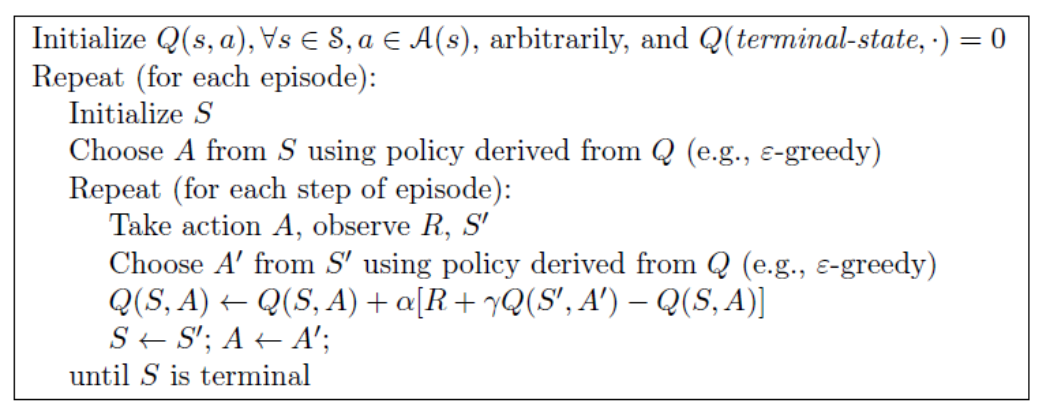

In [23]:
# sarsa 알고리즘으로 수정
def sarsa(s, a, r, s_next, a_next, Q, alpha, gamma):
    if s_next == 8: # 목표 지점에 도달
        Q[s,a] = Q[s,a] + alpha*(r - Q[s,a])
    else:
        Q[s,a] = Q[s,a] + alpha*(r + gamma*Q[s_next, a_next] - Q[s,a])
    return Q

### 미로찾기 구현

In [24]:
def goal_maze(Q, epsilon, alpha, gamma, pi):
    s = 0
    a = a_next = get_action(s, Q, epsilon, pi) # 첫 번째 행동
    s_a_history = [[0, np.nan]]
    
    while True:
        a = a_next
        s_a_history[-1][1] = a
        s_next = get_s_next(s, a, Q, epsilon, pi)
        s_a_history.append([s_next, np.nan])
        
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            
        # 가치함수 수정
        Q = sarsa(s, a, r, s_next, a_next, Q, alpha, gamma)
        
        if s_next == 8:
            break
        else :
            s = s_next
    
    return [s_a_history, Q]

In [26]:
# 미로 빠져나오기

alpha = 0.1
gamma = 0.9
epsilon = 0.5
v =np.nanmax(Q, axis =1)
is_continue = True
episode = 1

while is_continue:
    print ('에피소드 : ' + str(episode))
    
    # epsilon을 조금씩 감소시킨다
    epsilon = epsilon/2
    [s_a_history, Q] = goal_maze(Q, epsilon, alpha, gamma, pi_0)
    
    new_v = np.nanmax(Q, axis=1)
    print("상태가치 함수 변화 : " + str(np.sum(np.abs(new_v-v))))
    v = new_v
    print("걸린 단계 수 : " + str(len(s_a_history) -1))
    
    # 에피소드 100번 반복
    episode = episode + 1
    if episode > 100 :
        break
    

에피소드 : 1
상태가치 함수 변화 : 0.0679200525787853
걸린 단계 수 : 8
에피소드 : 2
상태가치 함수 변화 : 0.011669899943082096
걸린 단계 수 : 4
에피소드 : 3
상태가치 함수 변화 : 0.010391768044554106
걸린 단계 수 : 4
에피소드 : 4
상태가치 함수 변화 : 0.009202549669401927
걸린 단계 수 : 4
에피소드 : 5
상태가치 함수 변화 : 0.00810224481762567
걸린 단계 수 : 4
에피소드 : 6
상태가치 함수 변화 : 0.007089464215422447
걸린 단계 수 : 4
에피소드 : 7
상태가치 함수 변화 : 0.006161757183804184
걸린 단계 수 : 4
에피소드 : 8
상태가치 함수 변화 : 0.005315882824844076
걸린 단계 수 : 4
에피소드 : 9
상태가치 함수 변화 : 0.004548033083477843
걸린 단계 수 : 4
에피소드 : 10
상태가치 함수 변화 : 0.0038540150480120827
걸린 단계 수 : 4
에피소드 : 11
상태가치 함수 변화 : 0.0037078282703288945
걸린 단계 수 : 4
에피소드 : 12
상태가치 함수 변화 : 0.0035308093722615785
걸린 단계 수 : 4
에피소드 : 13
상태가치 함수 변화 : 0.0033327395782077884
걸린 단계 수 : 4
에피소드 : 14
상태가치 함수 변화 : 0.003121536895635435
걸린 단계 수 : 4
에피소드 : 15
상태가치 함수 변화 : 0.002903552475549076
걸린 단계 수 : 4
에피소드 : 16
상태가치 함수 변화 : 0.0026838241801021567
걸린 단계 수 : 4
에피소드 : 17
상태가치 함수 변화 : 0.002466293167609601
걸린 단계 수 : 4
에피소드 : 18
상태가치 함수 변화 : 0.0022539885495730383
걸린 단계 수 : 